# Parametric linear elastic equation 

This notebook implements linear elastic deformation of thin plate where Young's modulus is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. 

## Problem description
We consider the in-plane deformation of the thin plate with the center plane given by $\Omega = (0, 1) \times (0, 1) \subset\mathbb{R}^2$. Suppose $E(x)$ is the Young's modulus at a point $x\in \Omega$ and $\nu$ Poisson ratio, $u = (u_1, u_2) : \Omega \to \mathbb{R}^2$ displacement field, $e(x) = \mathrm{sym} \nabla u = (\nabla u + \nabla u^T)/2$ linearized strain, $\sigma(x)$ Cauchy stress, and $b(x)$ body force per unit volume. The equation for $u$ is based on the balance of linear momentum and reads:
\begin{equation}\tag{1}
    \begin{aligned}
        -\nabla \cdot \sigma(x) &= b(x)\,, \qquad & \forall x\in \Omega\,,\\
        \sigma(x) &= \lambda(x) e_{ii} \mathrm{Id} + 2\mu(x) e\,, \qquad & \forall x \in \Omega\,,\\
        u(x) &= 0\,,\qquad &\forall x\in \Gamma_u\,,\\
        \sigma(x) n(x) &= t(x)\,, \qquad &\forall x\in \Gamma_q\,,\\
    \end{aligned}
\end{equation}
where, $\lambda$ and $\mu$ are Lam\'e parameters and are related to $E$ and $\nu$ as follows:
\begin{equation}\tag{2}
    \lambda(x) = \frac{E(x) \nu}{(1+\nu)(1-2\nu)} \quad \text{and} \quad \mu(x) = \frac{E(x)}{2(1+\nu)}\,.
\end{equation}
In Eq (1), $\Gamma_u := \left\{x\in \partial \Omega: x_1 < 1 \right\}$ and $\Gamma_q := \partial \Omega - \Gamma_u$, $n$ unit outward normal, and $t$ specified traction on the right edge of the domain. We assume that the field $E\in M$ is uncertain and the forward map $F: M \to U$ is defined such that given $E\in M$, $F(m) = u \in U$ solves the BVP Eq (1). The probability distribution for $E$ is given by
\begin{equation}\tag{3}
    E = \alpha_m * \log(w) + \mu_m, \qquad \text{where} \quad w \sim N(0, C)\,,
\end{equation}
with $C$ is the covariance operator and takes the same form as in [Poisson problem](../poisson/Poisson.ipynb). 

## Fixing parameters
We let
\begin{equation}\tag{4}
    b(x) = 0 \quad \text{and} \quad t(x) = 0e_1 + 10 e_2 
\end{equation}
and
\begin{equation}\tag{5}
\gamma_C = 0.8\,, \quad \delta_C = 0.2\,,\quad \eta_C = 1\,,\quad d_C = 2\,, \quad \alpha_m = 100\,, \quad \mu_m = 1000\,.
\end{equation}

## Random samples of m and corresponding solution u(m)

<p align="center"> <img src="./data/LinearElasticity_sample_plots.png" width="600"> </p>

In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl
import hippylib as hp

from scipy.interpolate import griddata

util_path = "../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot, field_plot_grid

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)

In [2]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Plotting utility

In [16]:
def plot_samples(m_vec, u_vec, nodes, u_tag, \
                save_fig = False, \
                save_fname = None):
    rows = len(m_vec)
    cols = 2
    fs = 20
    fig, axs = plt.subplots(rows, cols, figsize=(8, 12))

    cmap_vec = ['jet', 'viridis']

    for i in range(rows):

        for j in range(cols):
            if j == 0:
                cbar = field_plot(axs[i,j], m_vec[i], nodes, cmap = cmap_vec[j])
            else:
                cbar = field_plot(axs[i,j], \
                        u_vec[i], \
                        nodes, \
                        cmap = cmap_vec[j], \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)

            divider = make_axes_locatable(axs[i,j])
            cax = divider.append_axes('right', size='8%', pad=0.03)
            cax.tick_params(labelsize=fs)

            if j== 0:
                # format cbar ticks
                kfmt = lambda x, pos: "{:g}".format(x)
                
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
            else:
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
            
            if i == 0:
                axs[i,j].set_title(u_tag[j], fontsize=fs)
            axs[i,j].axis('off')
        
    fig.tight_layout()
    fig.suptitle('Samples of m and corresponding u(m)', fontsize=1.25*fs, y=1.025)
    if save_fig:
        fig.savefig(save_fname,  bbox_inches='tight')

    plt.show()


def plot_samples_grid(m_vec, u_vec, grid_x, grid_y, u_tag, \
                save_fig = False, \
                save_fname = None):
    rows = len(m_vec)
    cols = 2
    fs = 20
    fig, axs = plt.subplots(rows, cols, figsize=(8, 12))

    cmap_vec = ['jet', 'viridis']

    for i in range(rows):

        for j in range(cols):
            if j == 0:
                cbar = field_plot_grid(axs[i,j], m_vec[i], \
                                       grid_x, grid_y, cmap = cmap_vec[j])
            else:
                cbar = field_plot_grid(axs[i, j],\
                        u_vec[i], \
                        grid_x, \
                        grid_y, \
                        cmap = 'viridis', \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)

            divider = make_axes_locatable(axs[i,j])
            cax = divider.append_axes('right', size='8%', pad=0.03)
            cax.tick_params(labelsize=fs)

            if j== 0:
                # format cbar ticks
                kfmt = lambda x, pos: "{:g}".format(x)
                
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
            else:
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
            
            if i == 0:
                axs[i,j].set_title(u_tag[j], fontsize=fs)
            axs[i,j].axis('off')
        
    fig.tight_layout()
    fig.suptitle('Samples of m and corresponding u(m)', fontsize=1.25*fs, y=1.025)
    if save_fig:
        fig.savefig(save_fname,  bbox_inches='tight')

    plt.show()

# Main model class
This will also be moved to a python script after testing. The class has two component: (1) class to sample Young's modulus field using log-normal distribution in infinite dimension and (2) class that implements the variational form and solves it. 

In [4]:
class PriorSampler:
    
    def __init__(self, Vm, correlation_length, seed = 0, logn_scale = 100., logn_translate = 1000.):

        self.correlation_length = correlation_length
        var = self.correlation_length / 0.16
        # Delta and gamma
        self.delta = (var * self.correlation_length) ** (-0.5)
        self.gamma = self.delta * self.correlation_length ** 2

        self.seed = seed
        self.Vm = Vm

        self.prior = hp.BiLaplacianPrior(self.Vm, self.gamma, self.delta, robin_bc=True)
        self.translate = dl.Constant(logn_translate)
        self.scale = dl.Constant(logn_scale)
        
        self.parRandom = hp.Random(seed = seed)

        # initialize noise vector
        self.noise = dl.Vector()
        self.prior.init_vector(self.noise, "noise")
        self.parRandom.normal(1.,self.noise)
        
        # initialize sample
        self.sample = dl.Vector()
        self.prior.init_vector(self.sample, 0)

        # draw a sample
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.m_local = None
        self.m_fn = dl.Function(self.Vm)
        self.m_transform_fn = dl.Function(self.Vm)

        # set mean
        self.mean = self.prior.mean.copy()
        self.transform(self.mean)

    def transform(self, m):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., m)
        self.m_transform_fn = self.scale * dl.exp(self.m_fn) + self.translate
        
        self.m_local = dl.project(self.m_transform_fn, self.Vm).vector().get_local()
        m.set_local(self.m_local)


    def transform_pointwise(self, m):
        self.m_local = self.scale.values()[0]*np.exp(m.get_local()) + self.translate.values()[0]
        m.set_local(self.m_local)

    def get(self):
        self.sample.zero()
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.transform_pointwise(self.sample)
        return self.sample
    
class LinearElasticityModel:
    
    def __init__(self, correlation_length, seed = 0):
        
        # FE setup
        self.fe_order = 1
        self.nx = 50
        self.ny = 50
        self.mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), self.nx, self.ny)
        self.Vu = dl.VectorFunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vm = dl.FunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vh = [self.Vu, self.Vm, self.Vu] # state, parameter, adjoint

        # Boundary conditions
        self.b = dl.Constant((0, 0))
        self.t = dl.Constant((0, 10))
        
        self.bc = [dl.DirichletBC(self.Vu, dl.Constant((0,0)), self.boundaryLeft)]

        facets = dl.MeshFunction("size_t", self.mesh, self.mesh.topology().dim()-1)
        dl.AutoSubDomain(self.boundaryRight).mark(facets, 1)
        self.ds = dl.Measure("ds", domain=self.mesh, subdomain_data=facets)

        # variational form
        self.m_fn = dl.Function(self.Vm)
        self.u_fn = dl.Function(self.Vu)
        self.nu = 0.25
        self.lam_fact = dl.Constant(self.nu / (1+self.nu)*(1-2*self.nu))
        self.mu_fact = dl.Constant(1/(2*(1+self.nu)))
        
        self.u_trial = dl.TrialFunction(self.Vu)
        self.u_test = dl.TestFunction(self.Vu)

        self.d = self.u_fn.geometric_dimension()  # space dimension
        self.a = self.m_fn*dl.inner(self.lam_fact*dl.tr(dl.grad(self.u_trial))*dl.Identity(self.d) \
                                        + 2*self.mu_fact * dl.sym(dl.grad(self.u_trial)), \
                                    dl.sym(dl.grad(self.u_test)))*dl.dx
        
        self.L = dl.inner(self.b, self.u_test)*dl.dx + dl.inner(self.t, self.u_test)*self.ds 

        self.varf = self.a - self.L
    
        # setup prior for parameter field m
        self.prior_sampler = PriorSampler(self.Vm, correlation_length, seed)
        
    @staticmethod
    def boundaryLeft(x, on_boundary):
        return on_boundary and dl.near(x[0], 0.)
    
    @staticmethod
    def boundaryRight(x, on_boundary):
        return on_boundary and dl.near(x[0], 1.)
    
    def epsilon(self):
        return dl.sym(dl.grad(self.u_fn))

    def sigma(self):
        return self.m_fn*self.lam_fact*dl.tr(dl.grad(self.u_fn))*dl.Identity(self.d) \
                                        + 2*self.m_fn*self.mu_fact * dl.sym(dl.grad(self.u_fn))

    def solveFwd(self, m = None, m_is_fn = True):
        if m is not None:
            self.m_fn.vector().zero()
            if m_is_fn:
                self.m_fn.vector().axpy(1., m.vector())
            else:
                self.m_fn.vector()[:] = m


        self.A = dl.assemble(self.a)
        self.b = dl.assemble(self.L)
        for bc in self.bc:
            bc.apply(self.A, self.b)
        
        dl.solve(self.A, self.u_fn.vector(), self.b)

    def samplePrior(self):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., self.prior_sampler.get())

# Test LinearElasticity model

In [ ]:
correlation_length = 2
data_prefix = 'LinearElasticity'
model = LinearElasticityModel(correlation_length)
print(model.prior_sampler.gamma, model.prior_sampler.delta)

0.8 0.2


## Generate few samples of Youngs modulus and solve the forward problem

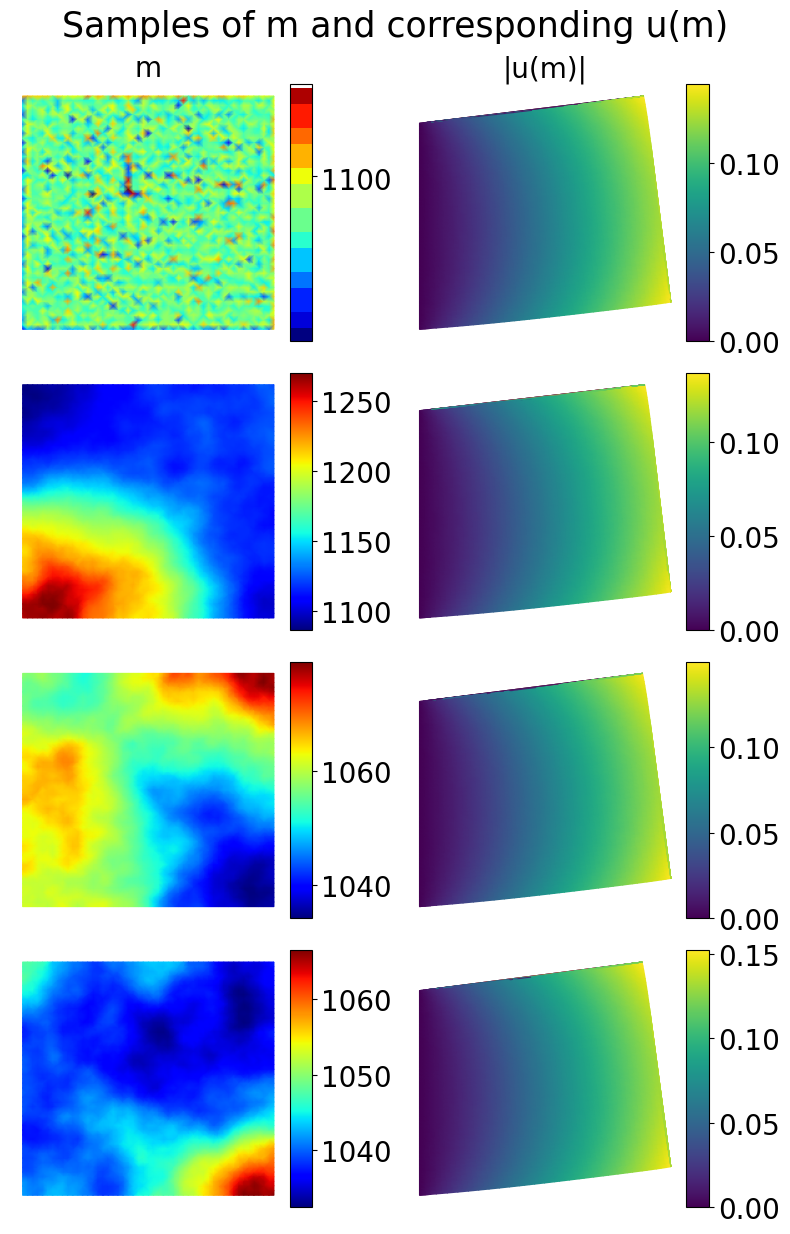

In [8]:
n_test_samples = 4

m_fn = dl.Function(model.Vm)
u_fn = dl.Function(model.Vu)

m_vec = []
u_vec = []

for i in range(n_test_samples):

    m_fn.vector().zero()
    if i > 0:
        m_fn.vector().axpy(1., model.prior_sampler.get())
    else:
        m_fn.vector().axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m_fn, m_is_fn = True)
    u_fn = model.u_fn

    m_vec.append(m_fn.compute_vertex_values())
    u_vec.append(u_fn.compute_vertex_values())

plot_samples(m_vec, u_vec, model.mesh.coordinates(), u_tag = ['m', '|u(m)|'])

In [9]:
a = model.prior_sampler.mean.get_local()
print('mean:', a.mean(), a.min(), a.max())
a = model.prior_sampler.get().get_local()
print('sample:', a.mean(), a.min(), a.max())

mean: 1099.9999999999989 1099.9999999999964 1100.000000000002
sample: 1207.5522830829275 1103.723475658667 1288.6000193056398


## Generate data

In [10]:
generate_data = True
if generate_data:
    num_samples = 2000

    m_samples = np.zeros((num_samples, model.Vm.dim()))
    u_samples = np.zeros((num_samples, model.Vu.dim()))

    m_fn = dl.Function(model.Vm)
    u_fn = dl.Function(model.Vu)

    for i in range(num_samples):

        start_time = time.perf_counter()

        m_fn.vector().zero()
        if i > 0:
            m_fn.vector().axpy(1., model.prior_sampler.get())
        else:
            m_fn.vector().axpy(1., model.prior_sampler.mean)
        
        model.solveFwd(m_fn, m_is_fn = True)
        u_fn = model.u_fn

        # save
        m_samples[i, :] = m_fn.compute_vertex_values()
        u_samples[i, :] = u_fn.compute_vertex_values()

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(m_samples.shape, u_samples.shape)

Sample    0 took 0.084 seconds
Sample  100 took 0.080 seconds
Sample  200 took 0.184 seconds
Sample  300 took 0.071 seconds
Sample  400 took 0.077 seconds
Sample  500 took 0.069 seconds
Sample  600 took 0.074 seconds
Sample  700 took 0.079 seconds
Sample  800 took 0.069 seconds
Sample  900 took 0.068 seconds
Sample 1000 took 0.084 seconds
Sample 1100 took 0.088 seconds
Sample 1200 took 0.068 seconds
Sample 1300 took 0.076 seconds
Sample 1400 took 0.069 seconds
Sample 1500 took 0.075 seconds
Sample 1600 took 0.074 seconds
Sample 1700 took 0.074 seconds
Sample 1800 took 0.070 seconds
Sample 1900 took 0.071 seconds
(2000, 2601) (2000, 5202)


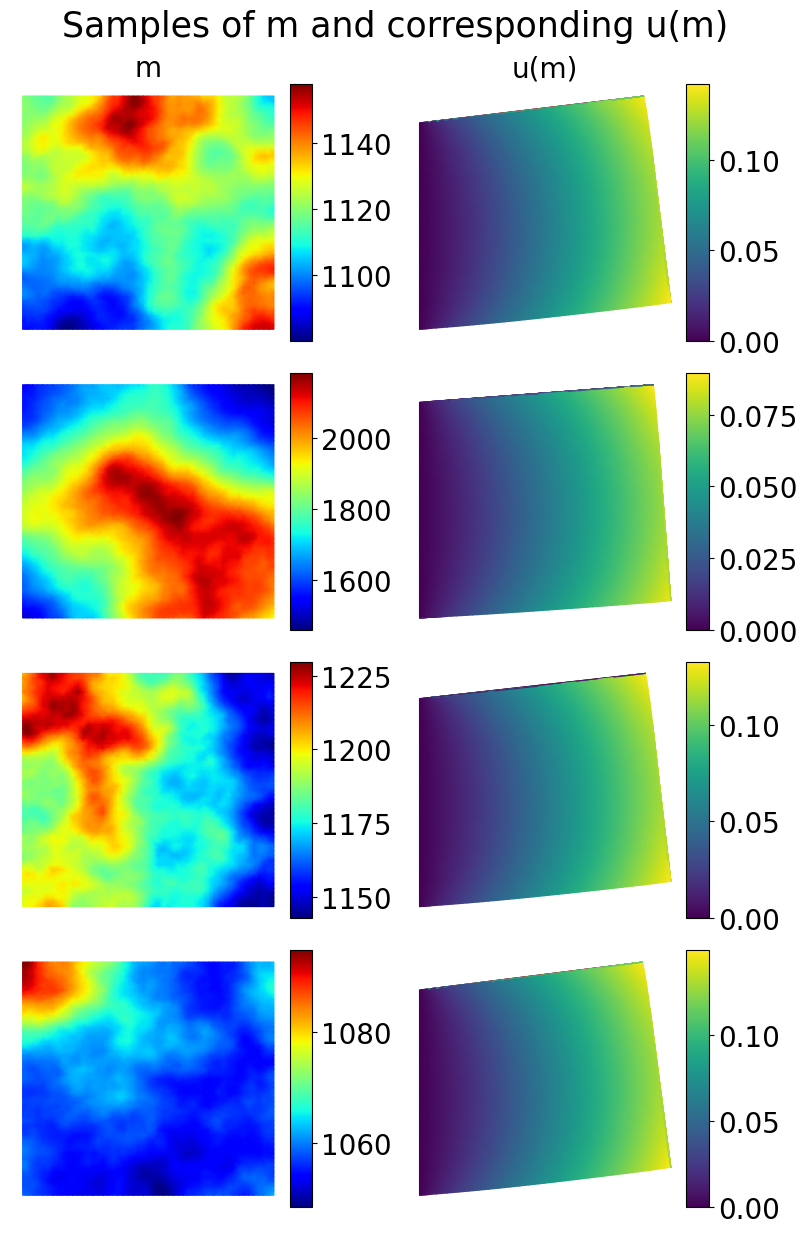

In [ ]:
if generate_data:    
    # plot 4 samples randomly chosen from the data
    i_choices = np.random.choice(num_samples, 4, replace=False)
    m_vec = [m_samples[i, :] for i in i_choices]
    u_vec = [u_samples[i, :] for i in i_choices]
    
    plot_samples(m_vec, u_vec, model.mesh.coordinates(), \
                u_tag = ['m', 'u(m)'], \
                save_fig = True, \
                save_fname = results_dir + data_prefix + '_sample_plots.png')

In [ ]:
if generate_data:
    # data to save
    np.savez(results_dir + data_prefix + '_samples.npz', \
            m_samples = m_samples, \
            u_samples = u_samples, num_samples = num_samples, \
            m_dim = model.Vm.dim(), u_dim = model.Vu.dim(), \
            fe_order = model.fe_order, nx = model.nx, ny = model.ny, \
            correlation_length = correlation_length, \
            gamma = model.prior_sampler.gamma, \
            delta = model.prior_sampler.delta, \
            alpha_m = model.prior_sampler.scale.values()[0], \
            mu_m = model.prior_sampler.translate.values()[0], \
            u_mesh_nodes = model.Vu.mesh().coordinates(), \
            m_mesh_nodes = model.Vm.mesh().coordinates(), \
            u_mesh_elements = model.Vu.mesh().cells(), \
            m_mesh_elements = model.Vm.mesh().cells())


    # save mesh 
    ## to read, use the syntax
    ## mesh = dl.Mesh()
    ## with dl.XDMFFile(results_dir + 'u_mesh.xdmf') as infile:
    ##     infile.read(mesh)
    with dl.XDMFFile(results_dir + data_prefix + '_u_mesh.xdmf') as infile:
        infile.write(model.Vu.mesh())

    with dl.XDMFFile(results_dir + data_prefix + '_m_mesh.xdmf') as infile:
        infile.write(model.Vm.mesh())

In [13]:
print('m_mesh_nodes shape: {}\nu_mesh_nodes shape: {}\nm_dim: {}\nu_dim: {}'.format(model.Vm.mesh().coordinates().shape, model.Vu.mesh().coordinates().shape, model.Vm.dim(), model.Vu.dim()))

m_mesh_nodes shape: (2601, 2)
u_mesh_nodes shape: (2601, 2)
m_dim: 2601
u_dim: 5202


## Interpolate function at nodal values to meshgrid for FNO

### Compute and plot interpolation over grid

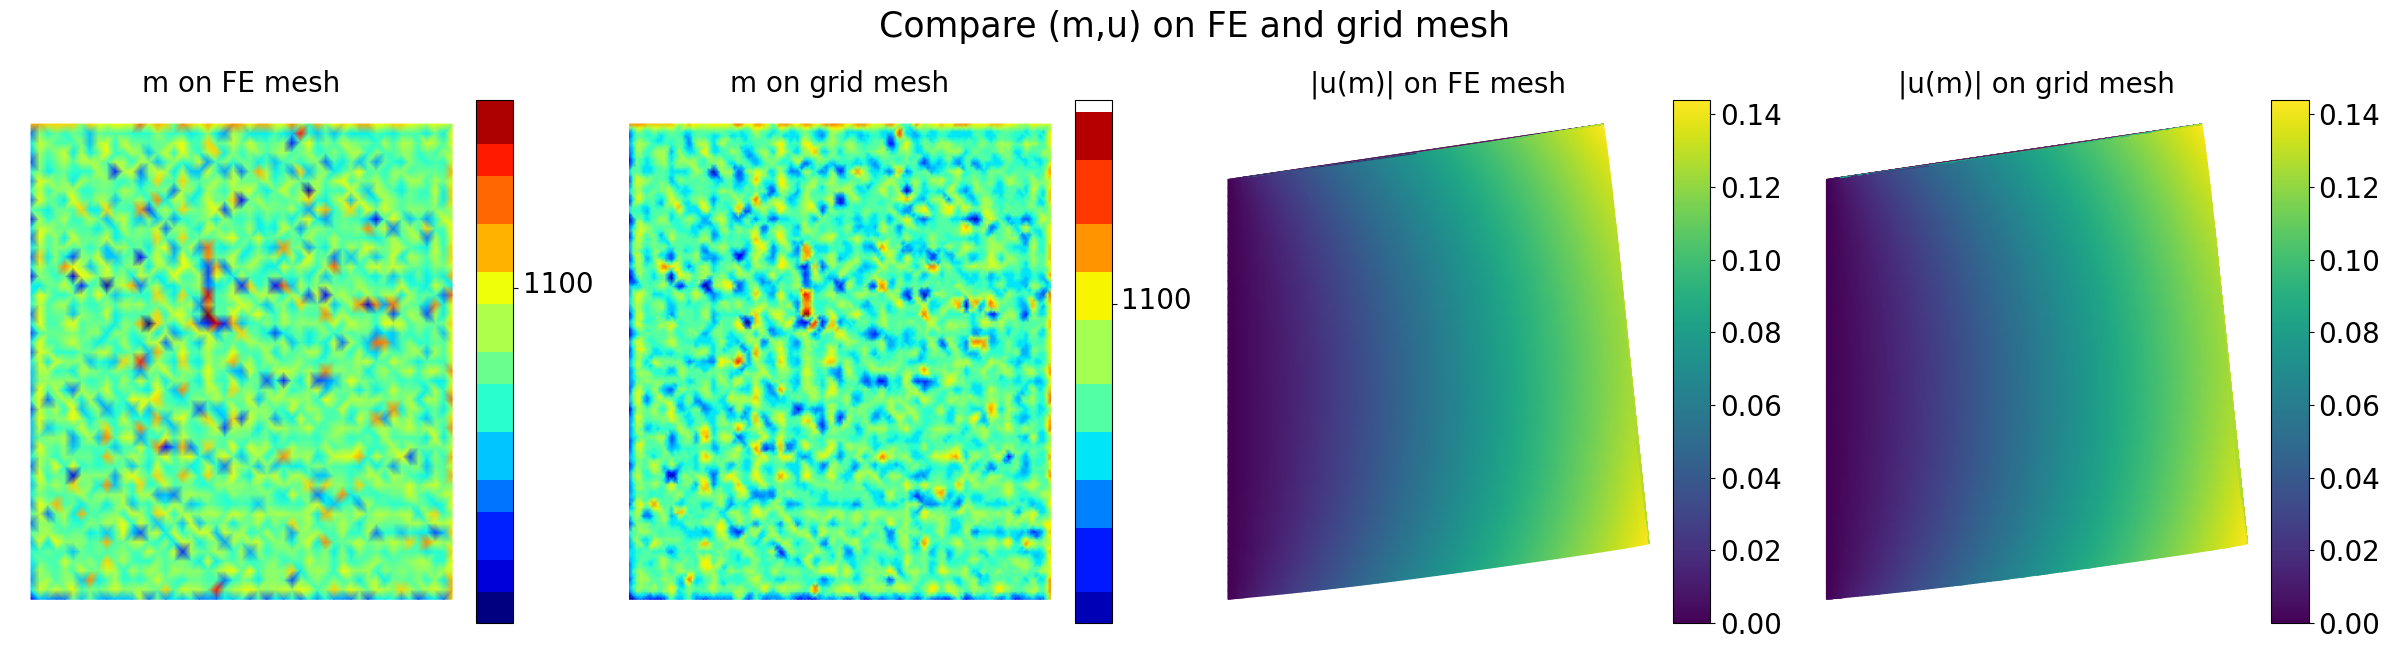

In [ ]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')
fe_u_nodes = data_load['u_mesh_nodes']
fe_m_nodes = data_load['m_mesh_nodes']
num_nodes = fe_u_nodes.shape[0]

# get one sample
m_fn = dl.Function(model.Vm)
m_fn.vector().axpy(1., model.prior_sampler.mean)
model.solveFwd(m_fn, m_is_fn = True)
u_fn = model.u_fn

m = m_fn.compute_vertex_values(model.Vm.mesh())
u = u_fn.compute_vertex_values(model.Vu.mesh())

# use interpolation to get data on grid
num_grid_x, num_grid_y = 121, 121
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y))

# interpolate m and u on grid
grid_m = griddata(fe_m_nodes, m, (grid_x, grid_y), method='linear')
grid_u = np.zeros((num_grid_x, num_grid_y, 2))
grid_u[:, :, 0] = griddata(fe_u_nodes, u[:num_nodes], (grid_x, grid_y), method='linear')
grid_u[:, :, 1] = griddata(fe_u_nodes, u[num_nodes:], (grid_x, grid_y), method='linear')

# plot function on FE mesh and compare with the function on grid

rows = 1
cols = 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(24, 6))

for i in range(cols):
    
    if i%2 == 0:
        # use plotter without element data
        if i == 0:
            cbar = field_plot(axs[i], m, fe_m_nodes, cmap = 'jet')
            axs[i].set_title('m on FE mesh', fontsize = fs)
        else:
            cbar = field_plot(axs[i], \
                        u, \
                        fe_u_nodes, \
                        cmap = 'viridis', \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
            axs[i].set_title('|u(m)| on FE mesh', fontsize = fs)
    else:
        # use griddata
        if i == 1:
            cbar = field_plot_grid(axs[i], grid_m, grid_x, grid_y, cmap = 'jet')
            axs[i].set_title('m on grid mesh', fontsize = fs)
        else:
            cbar = field_plot_grid(axs[i],\
                        grid_u, \
                        grid_x, \
                        grid_y, \
                        cmap = 'viridis', \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
            axs[i].set_title('|u(m)| on grid mesh', fontsize = fs)

    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='8%', pad=0.03)
    cax.tick_params(labelsize=fs)

    if i < 2:
        # format cbar ticks
        kfmt = lambda x, pos: "{:g}".format(x)
        
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
    else:
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

    axs[i].axis('off')

fig.tight_layout()
fig.suptitle('Compare (m,u) on FE and grid mesh', fontsize=1.25*fs, y=1.075)
fig.savefig(results_dir + data_prefix + '_compare_FE_and_grid_mesh.png',  bbox_inches='tight')
plt.show()


### Interpolate all samples to grid and save to file for FNO

In [ ]:
# save all samples to file
generate_fno_data = True
if generate_fno_data:

    num_grid_x, num_grid_y = 121, 121
    print('Generating FNO data for grid sizes ({}, {})'.format(num_grid_x, num_grid_y))

    # get grid coordinates
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y))

    # load data
    data_load = np.load(results_dir + data_prefix + '_samples.npz')
    
    fe_m_nodes = data_load['m_mesh_nodes']
    fe_u_nodes = data_load['u_mesh_nodes']
    num_nodes = fe_u_nodes.shape[0]

    m_samples = data_load['m_samples']
    u_samples = data_load['u_samples']

    num_samples = m_samples.shape[0]
    
    # interpolate samples on grid
    grid_m_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    grid_u_samples = np.zeros((num_samples, num_grid_x, num_grid_y, 2))
    for i in range(num_samples):
        start_time = time.perf_counter()
        
        grid_m_samples[i, :, :] = griddata(fe_m_nodes, m_samples[i, :], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :, 0] = griddata(fe_u_nodes, u_samples[i, :num_nodes], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :, 1] = griddata(fe_u_nodes, u_samples[i, num_nodes:], (grid_x, grid_y), method='linear')

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(grid_m_samples.shape, grid_u_samples.shape)

Generating FNO data for grid sizes (121, 121)
Sample    0 took 0.139 seconds
Sample  100 took 0.137 seconds
Sample  200 took 0.142 seconds
Sample  300 took 0.148 seconds
Sample  400 took 0.140 seconds
Sample  500 took 0.138 seconds
Sample  600 took 0.137 seconds
Sample  700 took 0.143 seconds
Sample  800 took 0.131 seconds
Sample  900 took 0.139 seconds
Sample 1000 took 0.143 seconds
Sample 1100 took 0.130 seconds
Sample 1200 took 0.128 seconds
Sample 1300 took 0.133 seconds
Sample 1400 took 0.136 seconds
Sample 1500 took 0.134 seconds
Sample 1600 took 0.145 seconds
Sample 1700 took 0.137 seconds
Sample 1800 took 0.150 seconds
Sample 1900 took 0.144 seconds
(2000, 121, 121) (2000, 121, 121, 2)


m_vec shape: (121, 121)
u_vec shape: (121, 121, 2)
m_vec shape: (121, 121)
u_vec shape: (121, 121, 2)
m_vec shape: (121, 121)
u_vec shape: (121, 121, 2)
m_vec shape: (121, 121)
u_vec shape: (121, 121, 2)


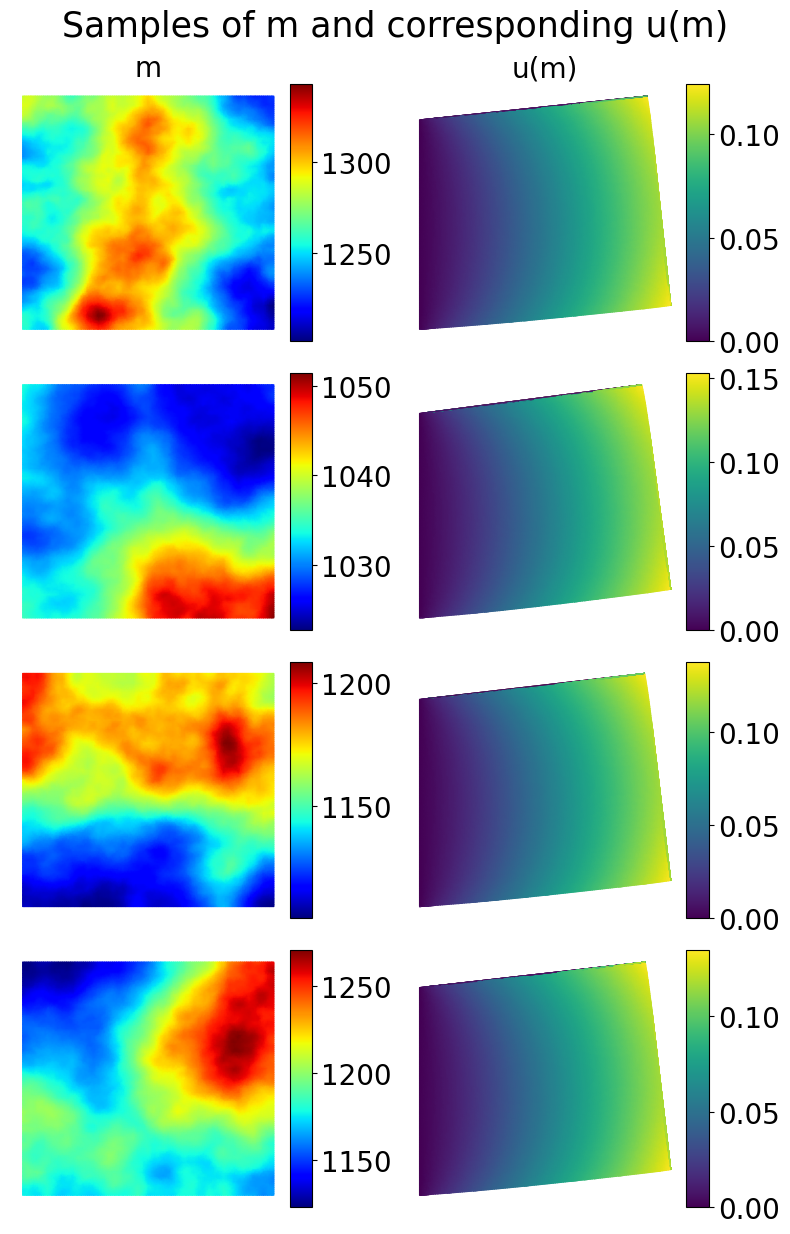

In [ ]:
if generate_fno_data:    
    # plot 4 samples randomly chosen from the data
    i_choices = np.random.choice(num_samples, 4, replace=False)
    m_vec = [grid_m_samples[i, :, :] for i in i_choices]
    u_vec = [grid_u_samples[i, :, :, :] for i in i_choices]

    for i in range(len(i_choices)):
        print('m_vec shape: {}\nu_vec shape: {}'.format(m_vec[i].shape, u_vec[i].shape))
    
    plot_samples_grid(m_vec, u_vec, grid_x, grid_y, \
                u_tag = ['m', 'u(m)'], \
                save_fig = True, \
                save_fname = \
                    results_dir + data_prefix + '_sample_plots_on_grid.png')

In [ ]:
# data to save
if generate_fno_data:
        np.savez(results_dir + data_prefix + '_FNO_samples.npz', \
                grid_m_samples = grid_m_samples, \
                grid_u_samples = grid_u_samples, \
                num_samples = num_samples, \
                num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
                grid_x = grid_x, grid_y = grid_y)

### Load data to test

In [ ]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')

print('num_samples: {}\nm_samples shape: {}\nu_samples shape: {}\nm_dim: {}\nu_dim: {}'.format(data_load['num_samples'], data_load['m_samples'].shape, data_load['u_samples'].shape, data_load['m_dim'], data_load['u_dim']))

num_samples: 2000
m_samples shape: (2000, 2601)
u_samples shape: (2000, 5202)
m_dim: 2601
u_dim: 5202


In [ ]:
data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')
print('num_samples: {}\ngrid_m_samples shape: {}\ngrid_u_samples shape: {}'.format(data_load['num_samples'], data_load['grid_m_samples'].shape, data_load['grid_u_samples'].shape))

num_samples: 2000
grid_m_samples shape: (2000, 121, 121)
grid_u_samples shape: (2000, 121, 121, 2)
